In [3]:
#simply change the string to wherever the RunSummaries.txt file is stored and run the rest of the cells 
runSummariesFileLocation = "/Users/psmith/Desktop/REUSE/poster/data/RunSummaries.txt"

In [4]:
from scipy import interpolate
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys


In [5]:
def SeparateRunSummaries(runSummariesFileLocation):
    """Takes log with both secure and unsecure data and separates them into two files. 
    Only meant to be used with log file from run_experiments.sh"""
    
    f = open(runSummariesFileLocation, "r")
    lines = f.readlines()
    f.close()

    i = 0
    for line in lines:
        if line.startswith("secure"):
            break
        i += 1

    f = open("unsecureLog.txt", "w")
    f.writelines(lines[:i])
    f.close()

    f = open("secureLog.txt", "w")
    f.writelines(lines[i:])
    f.close()


In [6]:
def ParseExperimentData(runSummariesFileLocation):
    """Return a dataframe containing all experiment data"""
    f = open(runSummariesFileLocation, "r")
    experimentLog = f.read()
    f.close()
    
    #parse out min and max particle counts
    parameters = re.findall("secure(\d+)-(\d+)", experimentLog)
    minParticleCount = []
    maxParticleCount = []
    for param in parameters:
        minParticleCount.append(param[0])
        maxParticleCount.append(param[1])
    
    #parse out collected data
    navTimes = re.findall("Navigation\stime:(\s\d+\.\d+)\sseconds", experimentLog)
    controlLoop = re.findall("Control\sloop\smissed\sdesired\srate\s(\d+)\stimes", experimentLog)
    completedNav = re.findall("Completed\snavigation\?\s(\w)", experimentLog)
    activatedWaitTimes = re.findall("Turtlebot\sactivated\swait\s(\d+)\stimes", experimentLog)
    averageCpuUtilization = re.findall("Average\sCPU\sutilization\s=\s(\d+\.\d+)", experimentLog)
    
    #Some navigation failures caused localization error to be nan so regex not as specific 
    xLocalizationError = re.findall("Average\sx\slocalization\serror:\s(.+)", experimentLog)
    yLocalizationError = re.findall("Average\sy\slocalization\serror:\s(.+)", experimentLog)
    
    finalDistanceFromGoal = re.findall("Final\sdistance\sfrom\sgoal:\s(\d+\.\d+)\smeters", experimentLog)
    totalChangeInYaw = re.findall("Total\schange\sin\syaw:\s\s(\d+\.\d+)\sdegrees", experimentLog)
    changeInYawPerSecond = re.findall("Change\sin\syaw\sper\ssecond:\s(\d+\.\d+)\sdeg/s", experimentLog)
    
    #create a dictionary to pass to DataFrame constructor
    data = {'Max particles': maxParticleCount, 'Min particles': minParticleCount,
            'Total nav time': navTimes, 'Control loop missed': controlLoop,
            'Completed nav?': completedNav, 'Number of waits': activatedWaitTimes,
            'CPU Utilization': averageCpuUtilization, 'x localization error': xLocalizationError, 
            'y localization error': yLocalizationError, 'Final distance from goal': finalDistanceFromGoal,
            'Change in yaw': totalChangeInYaw, 'Change in yaw/s': changeInYawPerSecond}
    
    #create DataFrame and encode categorical data that specifies whether navigation completed 
    #max particle count not set 
    experimentDf = pd.DataFrame(data=data)
    experimentDf.replace("D", 0, inplace=True) #D stood for did not finish
    experimentDf.replace("F", 1, inplace=True) #F stood for finished
    
    #change string data types to float/int to allow DataFrame operations
    numericExpData = experimentDf.astype({'Max particles': 'int32', 'Min particles': 'float64',
                                          'Total nav time': 'float64', 'Completed nav?': 'float64', 
                                          'Control loop missed': "float64", 'Number of waits': 'float64', 
                                          'CPU Utilization': 'float64', 'x localization error': 'float64', 
                                          'y localization error': 'float64', 'Final distance from goal': 'float64',
                                          'Change in yaw': 'float64', 'Change in yaw/s': 'float64'})
    
    return numericExpData
    
    

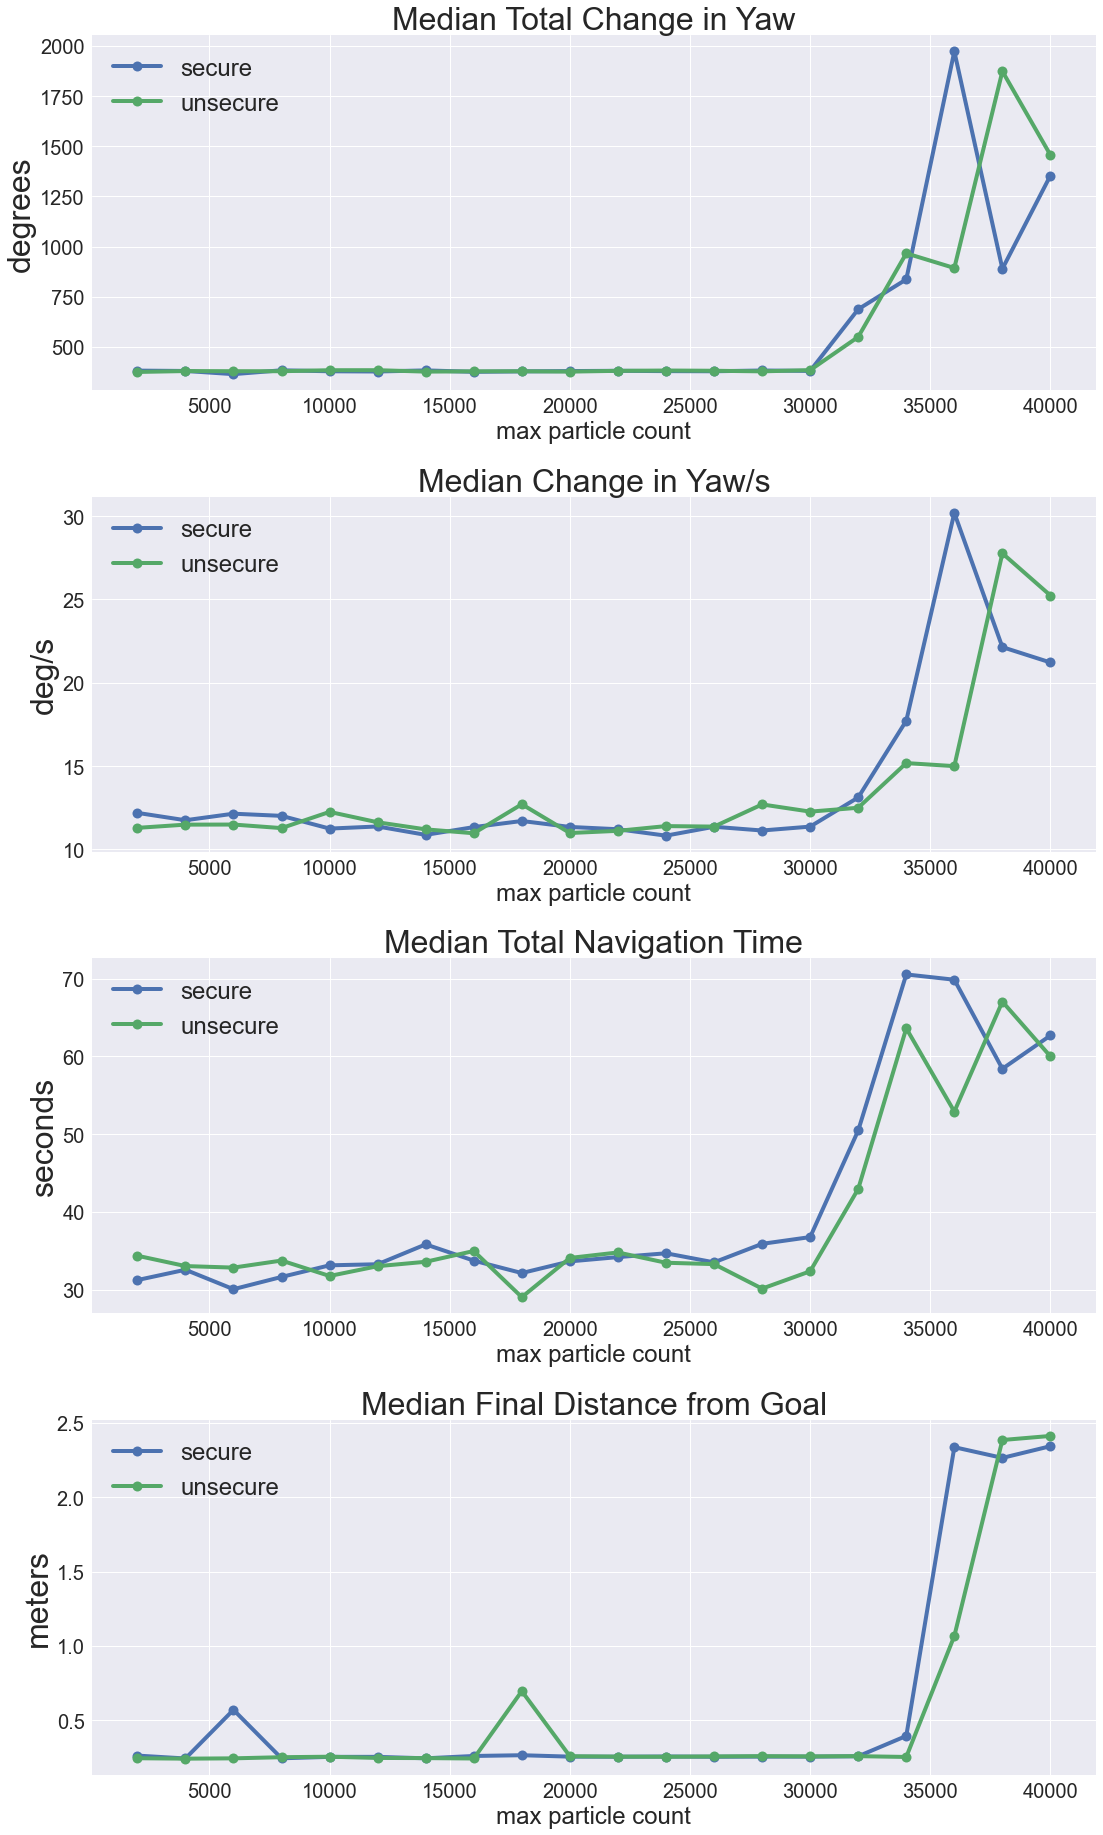

In [10]:
#separate total run summary file into two separate files to make parsing into separate data frames easier
SeparateRunSummaries(runSummariesFileLocation)

#create DataFrames for the unsecure and secure data
unsecureDf = ParseExperimentData("unsecureLog.txt")
secureDf = ParseExperimentData("secureLog.txt")

#Group DataFrames by Max particle count and calculate median 
#Failures are not uncommon even at lower particle counts, which can throw off the mean
unsecureMedians = unsecureDf.groupby(['Max particles'], sort=True).median()
secureMedians = secureDf.groupby(['Max particles'], sort=True).median()

#Format plots to look nice
plt.style.use('seaborn')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.rc('lines', linewidth=4)

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=False, sharey=False, figsize=(18, 32))
fig.subplots_adjust(hspace = 0.3)

#plot medians for metrics found to be most indicative of performance 
ax[0].plot(secureMedians["Change in yaw"], label='secure', marker='o', markersize=10)
ax[0].plot(unsecureMedians["Change in yaw"], label='unsecure', marker='o', markersize=10)
ax[0].set_title("Median Total Change in Yaw", fontsize=32)
ax[0].set_ylabel("degrees", fontsize=32)
ax[0].set_xlabel("max particle count", fontsize=24)
ax[0].legend(fontsize=24)

ax[1].plot(secureMedians["Change in yaw/s"], label='secure', marker='o', markersize=10)
ax[1].plot(unsecureMedians["Change in yaw/s"], label='unsecure', marker='o', markersize=10)
ax[1].set_title("Median Change in Yaw/s", fontsize=32)
ax[1].set_ylabel("deg/s", fontsize=32)
ax[1].set_xlabel("max particle count", fontsize=24)
ax[1].legend(fontsize=24)

ax[2].plot(secureMedians["Total nav time"], label='secure', marker='o', markersize=10)
ax[2].plot(unsecureMedians["Total nav time"], label='unsecure', marker='o', markersize=10)
ax[2].set_title("Median Total Navigation Time", fontsize=32)
ax[2].set_ylabel("seconds", fontsize=32)
ax[2].set_xlabel("max particle count", fontsize=24)
ax[2].legend(fontsize=24)

ax[3].plot(secureMedians["Final distance from goal"], label='secure', marker='o', markersize=10)
ax[3].plot(unsecureMedians["Final distance from goal"], label='unsecure', marker='o', markersize=10)
ax[3].set_title("Median Final Distance from Goal", fontsize=32)
ax[3].set_ylabel("meters", fontsize=32)
ax[3].set_xlabel("max particle count", fontsize=24)
ax[3].legend(fontsize=24)

plt.show()

In [11]:
#I chose to remove outliers on an individual column basis, so not all metrics may end up removing the same runs as outliers
def RemoveOutliers(df, column, groupByMax=True):
    """Removes outliers within a single column of a DataFrame. By default returns Df grouped by max particle count."""
    
    #Reindex dataframe to Max particles and assign the desired column to a new df
    reindexedDf = pd.DataFrame(df.set_index(['Max particles'])[column])
    reindexedDf.sort_index(inplace=True)
    
    #Use groupby and describe() to calculate quartiles
    describeDf = reindexedDf.groupby(['Max particles']).describe()
    
    #interquartile range = Q3 - Q1
    iqr = describeDf[column]['75%'] - describeDf[column]['25%']
    
    #calculate outliers
    #magic numbers in particle counts and run amount, but didn't want too many parameters
    particles = 2000
    dfIndex = 0 
    while particles <= 40000:
        run = 0
        while run < 10:
            #lower outlier < Q1 – 1.5×IQR, upper outlier > Q3 + 1.5×IQR
            if float(reindexedDf.loc[particles].iloc[run]) < (describeDf[column]["25%"].loc[particles] - iqr.loc[particles]) or float(reindexedDf.loc[particles].iloc[run]) > (describeDf[column]["75%"].loc[particles] + iqr.loc[particles]):
                #assign outlier index to None so it can be easily removed later once all outliers are found
                reindexedDf.iloc[dfIndex] = None
            run += 1
            dfIndex += 1
        
        particles += 2000
    
    reindexedDf.dropna(inplace=True)
    
    if groupByMax:
        return reindexedDf.groupby(['Max particles'])
    else:
        return reindexedDf

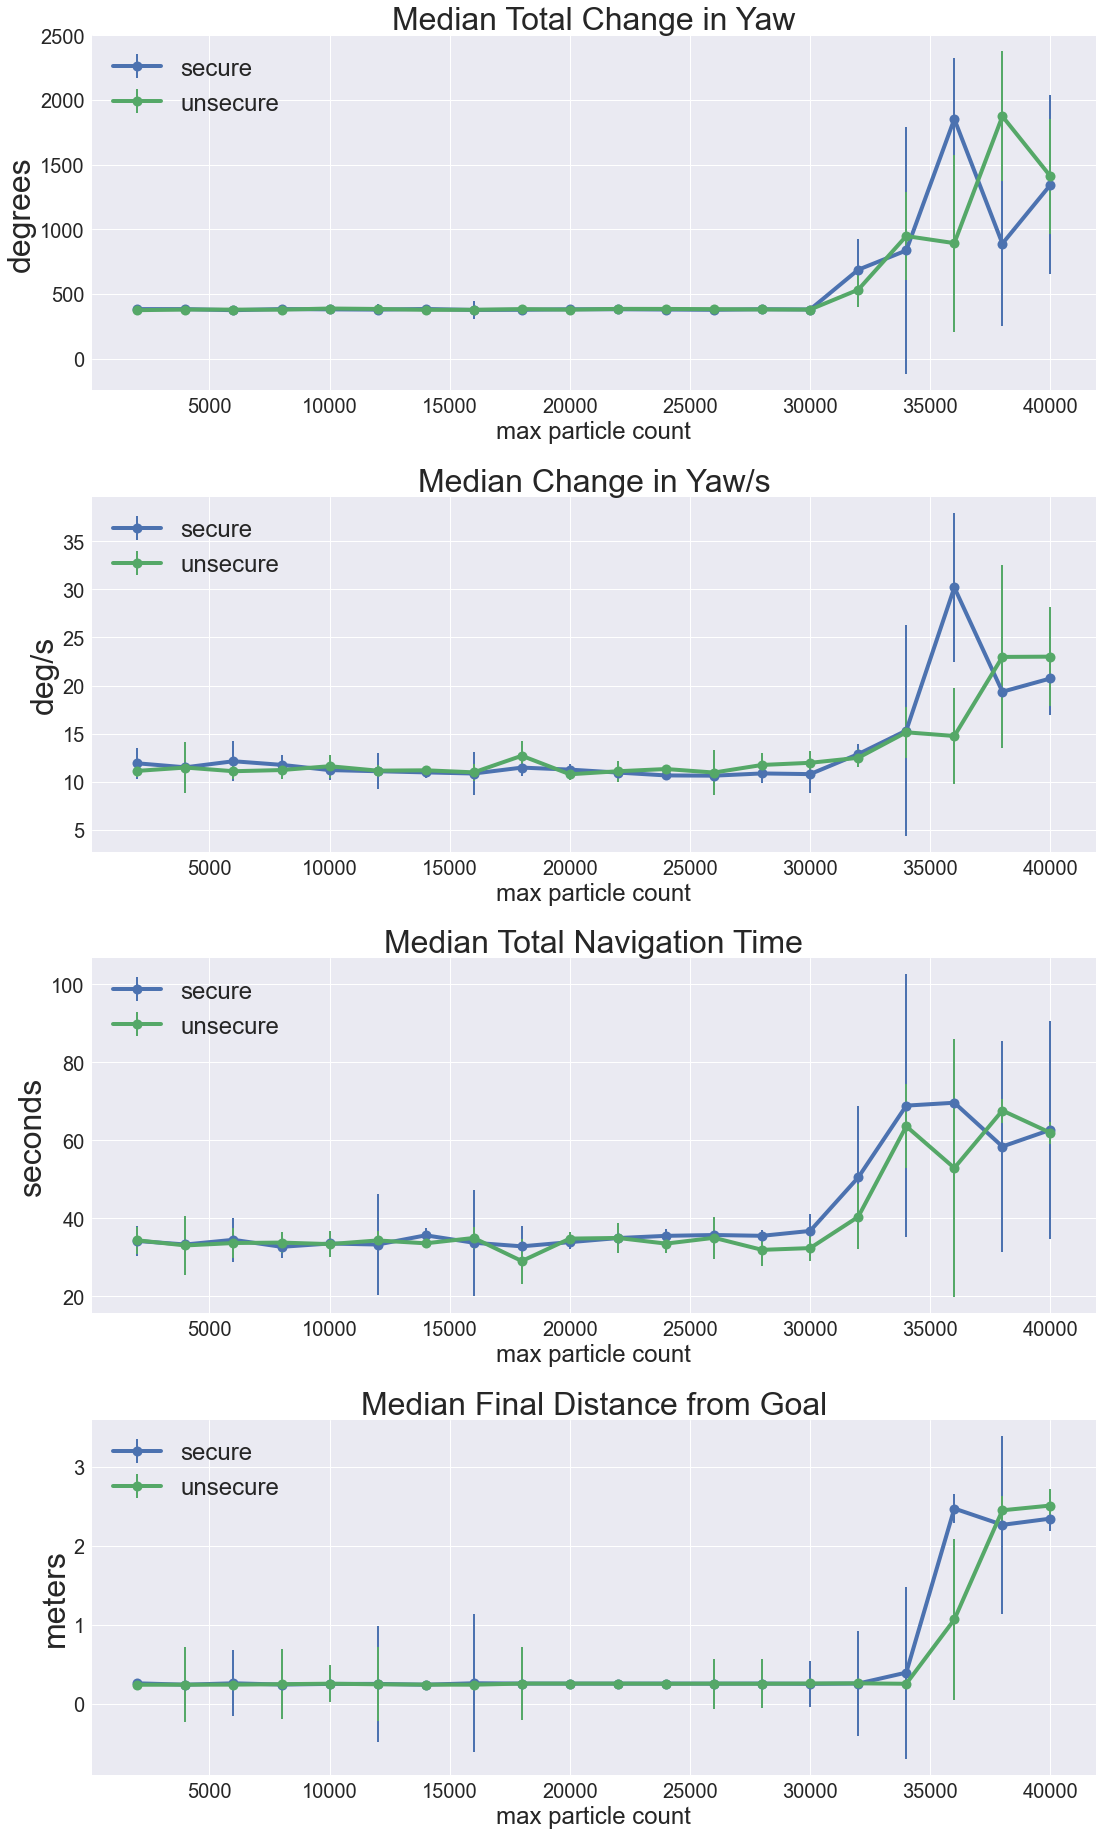

In [12]:
#Plot medians after removing outliers with error bars showing standard deviation for each configuration
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=False, sharey=False, figsize=(18, 32))
fig.subplots_adjust(hspace = 0.3)

secureYaw = RemoveOutliers(secureDf, "Change in yaw")
secMed = secureYaw.median()
secErr = secureYaw.std()
x = secMed.index

unsecureYaw = RemoveOutliers(unsecureDf, "Change in yaw")
med = unsecureYaw.median()
x = unsecureYaw.std().index
err = unsecureYaw.std()

ax[0].errorbar(x, secMed['Change in yaw'], yerr=secErr['Change in yaw'], marker='o', markersize=10, elinewidth=2, label='secure')
ax[0].errorbar(x, med['Change in yaw'], yerr=err['Change in yaw'], marker='o', markersize=10, elinewidth=2, label='unsecure')
ax[0].set_title("Median Total Change in Yaw", fontsize=32)
ax[0].set_ylabel("degrees", fontsize=32)
ax[0].set_xlabel("max particle count", fontsize=24)
ax[0].legend(fontsize=24, loc=2)

secureYawRate = RemoveOutliers(secureDf, "Change in yaw/s")
secMed = secureYawRate.median()
secErr = secureYawRate.std()
x = secMed.index

unsecureYawRate = RemoveOutliers(unsecureDf, "Change in yaw/s")
med = unsecureYawRate.median()
x = unsecureYawRate.std().index
err = unsecureYawRate.std()

ax[1].errorbar(x, secMed['Change in yaw/s'], yerr=secErr['Change in yaw/s'], marker='o', markersize=10, elinewidth=2, label='secure')
ax[1].errorbar(x, med['Change in yaw/s'], yerr=err['Change in yaw/s'], marker='o', markersize=10, elinewidth=2, label='unsecure')
ax[1].set_title("Median Change in Yaw/s", fontsize=32)
ax[1].set_ylabel("deg/s", fontsize=32)
ax[1].set_xlabel("max particle count", fontsize=24)
ax[1].legend(fontsize=24, loc=2)

secureNavTime = RemoveOutliers(secureDf, "Total nav time")
secMed = secureNavTime.median()
secErr = secureNavTime.std()
x = secMed.index

unsecureNavTime = RemoveOutliers(unsecureDf, "Total nav time")
med = unsecureNavTime.median()
x = unsecureNavTime.std().index
err = unsecureNavTime.std()

ax[2].errorbar(x, secMed['Total nav time'], yerr=secErr['Total nav time'], marker='o', markersize=10, elinewidth=2, label='secure')
ax[2].errorbar(x, med['Total nav time'], yerr=err['Total nav time'], marker='o', markersize=10, elinewidth=2, label='unsecure')
ax[2].set_title("Median Total Navigation Time", fontsize=32)
ax[2].set_ylabel("seconds", fontsize=32)
ax[2].set_xlabel("max particle count", fontsize=24)
ax[2].legend(fontsize=24, loc=2)

secureDistance = RemoveOutliers(secureDf, "Final distance from goal")
secMed = secureDistance.median()
secErr = secureDistance.std()
x = secMed.index

unsecureDistance = RemoveOutliers(unsecureDf, "Final distance from goal")
med = unsecureDistance.median()
x = unsecureDistance.std().index
err = unsecureDistance.std()

ax[3].errorbar(x, secMed['Final distance from goal'], yerr=secErr['Final distance from goal'], marker='o', markersize=10, elinewidth=2, label='secure')
ax[3].errorbar(x, med['Final distance from goal'], yerr=err['Final distance from goal'], marker='o', markersize=10, elinewidth=2, label='unsecure')
ax[3].set_title("Median Final Distance from Goal", fontsize=32)
ax[3].set_ylabel("meters", fontsize=32)
ax[3].set_xlabel("max particle count", fontsize=24)
ax[3].legend(fontsize=24, loc=2)
fig.savefig("/Users/psmith/Desktop/REUSE/poster/figures/median-errorbars.png")

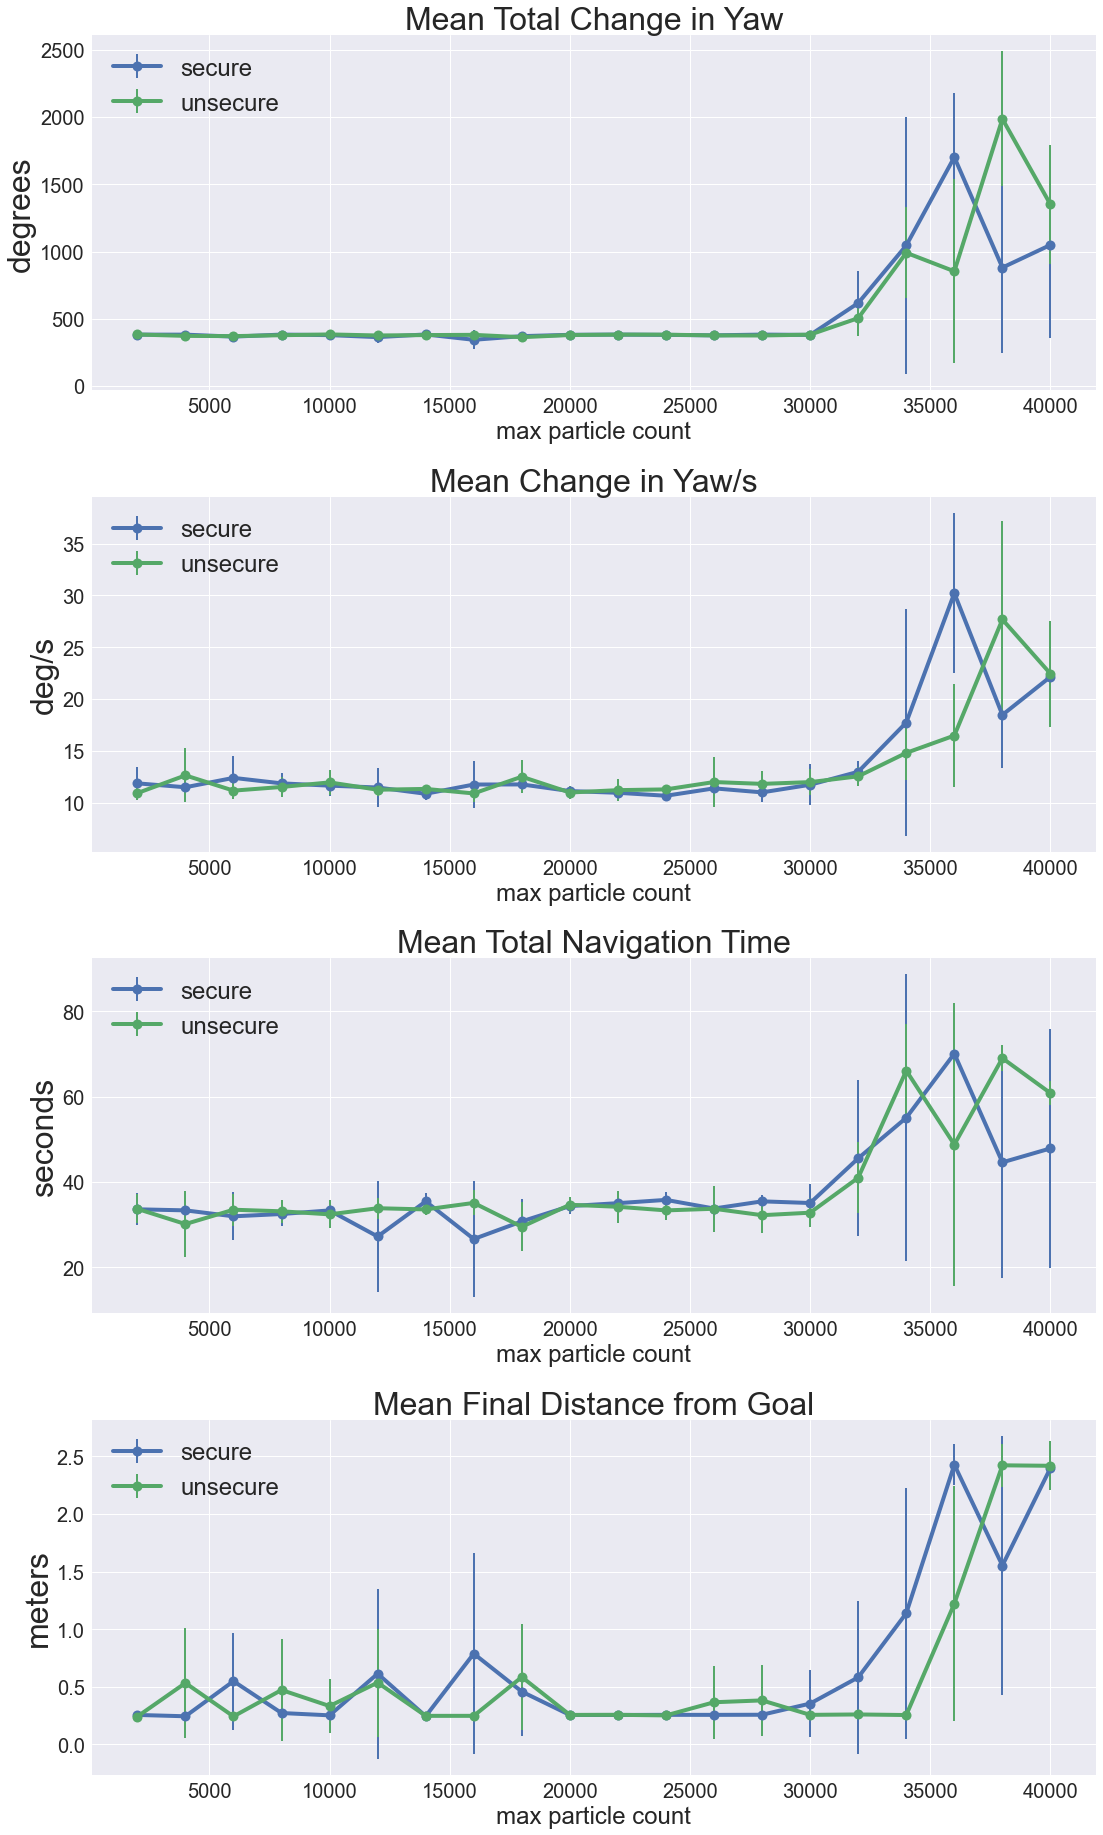

In [13]:
#Plot means after removing outliers with error bars showing standard deviation for each configuration

fig, ax = plt.subplots(nrows=4, ncols=1, sharex=False, sharey=False, figsize=(18, 32))
fig.subplots_adjust(hspace = 0.3)

secureYaw = RemoveOutliers(secureDf, "Change in yaw")
secMean = secureYaw.mean()
secErr = secureYaw.std()
x = secMed.index

unsecureYaw = RemoveOutliers(unsecureDf, "Change in yaw")
mean = unsecureYaw.mean()
x = unsecureYaw.std().index
err = unsecureYaw.std()

ax[0].errorbar(x, secMean['Change in yaw'], yerr=secErr['Change in yaw'], marker='o', markersize=10, elinewidth=2, label='secure')
ax[0].errorbar(x, mean['Change in yaw'], yerr=err['Change in yaw'], marker='o', markersize=10, elinewidth=2, label='unsecure')
ax[0].set_title("Mean Total Change in Yaw", fontsize=32)
ax[0].set_ylabel("degrees", fontsize=32)
ax[0].set_xlabel("max particle count", fontsize=24)
ax[0].legend(fontsize=24, loc=2)

secureYawRate = RemoveOutliers(secureDf, "Change in yaw/s")
secMean = secureYawRate.mean()
secErr = secureYawRate.std()
x = secMed.index

unsecureYawRate = RemoveOutliers(unsecureDf, "Change in yaw/s")
mean = unsecureYawRate.mean()
x = unsecureYawRate.std().index
err = unsecureYawRate.std()

ax[1].errorbar(x, secMean['Change in yaw/s'], yerr=secErr['Change in yaw/s'], marker='o', markersize=10, elinewidth=2, label='secure')
ax[1].errorbar(x, mean['Change in yaw/s'], yerr=err['Change in yaw/s'], marker='o', markersize=10, elinewidth=2, label='unsecure')
ax[1].set_title("Mean Change in Yaw/s", fontsize=32)
ax[1].set_ylabel("deg/s", fontsize=32)
ax[1].set_xlabel("max particle count", fontsize=24)
ax[1].legend(fontsize=24, loc=2)

secureNavTime = RemoveOutliers(secureDf, "Total nav time")
secMean = secureNavTime.mean()
secErr = secureNavTime.std()
x = secMed.index

unsecureNavTime = RemoveOutliers(unsecureDf, "Total nav time")
mean = unsecureNavTime.mean()
x = unsecureNavTime.std().index
err = unsecureNavTime.std()

ax[2].errorbar(x, secMean['Total nav time'], yerr=secErr['Total nav time'], marker='o', markersize=10, elinewidth=2, label='secure')
ax[2].errorbar(x, mean['Total nav time'], yerr=err['Total nav time'], marker='o', markersize=10, elinewidth=2, label='unsecure')
ax[2].set_title("Mean Total Navigation Time", fontsize=32)
ax[2].set_ylabel("seconds", fontsize=32)
ax[2].set_xlabel("max particle count", fontsize=24)
ax[2].legend(fontsize=24, loc=2)

secureDistance = RemoveOutliers(secureDf, "Final distance from goal")
secMean = secureDistance.mean()
secErr = secureDistance.std()
x = secMed.index

unsecureDistance = RemoveOutliers(unsecureDf, "Final distance from goal")
mean = unsecureDistance.mean()
x = unsecureDistance.std().index
err = unsecureDistance.std()

ax[3].errorbar(x, secMean['Final distance from goal'], yerr=secErr['Final distance from goal'], marker='o', markersize=10, elinewidth=2, label='secure')
ax[3].errorbar(x, mean['Final distance from goal'], yerr=err['Final distance from goal'], marker='o', markersize=10, elinewidth=2, label='unsecure')
ax[3].set_title("Mean Final Distance from Goal", fontsize=32)
ax[3].set_ylabel("meters", fontsize=32)
ax[3].set_xlabel("max particle count", fontsize=24)
ax[3].legend(fontsize=24, loc=2)

In [14]:
#Create new DataFrames with outliers removed for each performance metric to perform further data analysis
unTotalYaw = RemoveOutliers(unsecureDf, 'Change in yaw', False)
unYawRate = RemoveOutliers(unsecureDf, 'Change in yaw/s', False)
unNavTime = RemoveOutliers(unsecureDf, 'Total nav time', False)
unDistance = RemoveOutliers(unsecureDf, 'Final distance from goal', False)

secTotalYaw = RemoveOutliers(secureDf, 'Change in yaw', False)
secYawRate = RemoveOutliers(secureDf, 'Change in yaw/s', False)
secNavTime = RemoveOutliers(secureDf, 'Total nav time', False)
secDistance = RemoveOutliers(secureDf, 'Final distance from goal', False)

In [30]:
def DisplayBoxplots(secureDf, unsecureDf, lb, ub, step):
    """Displays boxplots for secure and unsecure configurations for a certain performance metric over the upper range"""
    nrows = (ub - lb) // step + 1
    fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(10, 16))
    fig.subplots_adjust(hspace = 0.4)
    labels = ['secure', 'unsecure']
    
    particles = lb
    i = 0
    while particles <= ub:
        #turn DataFrame to numpy array and use flatten() to transform array into one dimension to allow plotting
        data = [secureDf.loc[particles].to_numpy().flatten(), unsecureDf.loc[particles].to_numpy().flatten()]
        ax[i].boxplot(data, labels=labels)
        ax[i].set_title("Max particle count: {}".format(particles), fontsize=16)
        particles += step
        i += 1

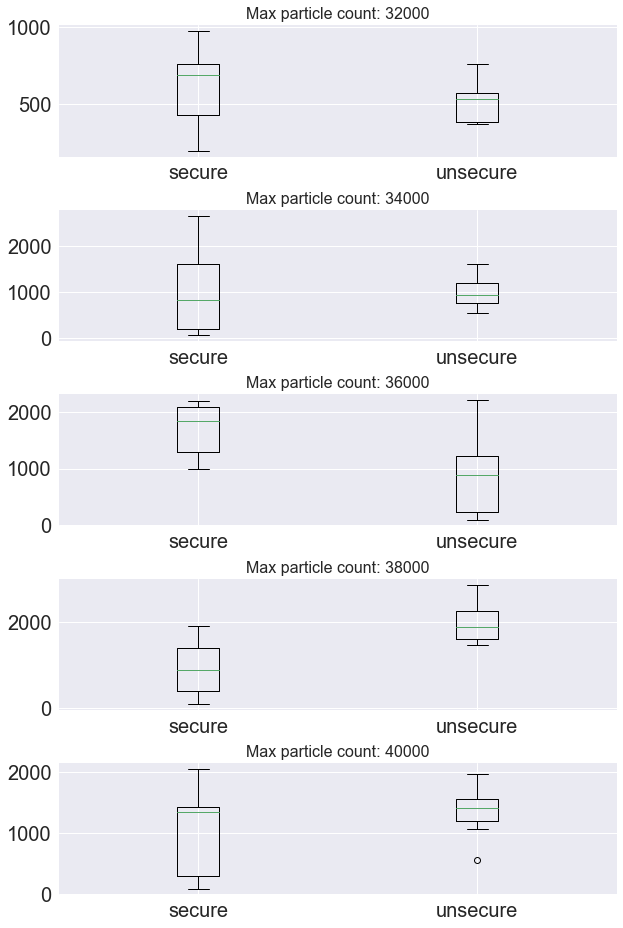

In [31]:
#Look at boxplots for each performance metric over upper range
DisplayBoxplots(secTotalYaw, unTotalYaw, 32000, 40000, 2000)

In [32]:
#Though calling every single boxplot above approximately normal is a stretch, we will do t tests over
# ideally there should be 30 or more points for each sample to satisfy
# the central limit theorem. 
from scipy.stats import ttest_ind

In [33]:
def PrintTtests(secureDf, unsecureDf, lb, ub, step):
    """Display t-tests between two samples over a given range"""
    particles = lb
    while particles <= ub:
        print("Particle count:", particles)
        print(ttest_ind(secureDf.loc[particles], unsecureDf.loc[particles]))
        particles += step

In [34]:
PrintTtests(secTotalYaw, unTotalYaw, 32000, 40000, 2000)

Particle count: 32000
Ttest_indResult(statistic=array([1.24937192]), pvalue=array([0.22845804]))
Particle count: 34000
Ttest_indResult(statistic=array([0.16158917]), pvalue=array([0.8735343]))
Particle count: 36000
Ttest_indResult(statistic=array([2.97523902]), pvalue=array([0.00892872]))
Particle count: 38000
Ttest_indResult(statistic=array([-4.02118604]), pvalue=array([0.00098708]))
Particle count: 40000
Ttest_indResult(statistic=array([-0.99612391]), pvalue=array([0.33609621]))
